# ARIMA - Autoregressive Moving Average Model
Author: Geovanna Santos Nobre de Oliveira

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

## Import data

In [3]:
path = '../../00_data'

In [4]:
data = pd.read_csv(f'{path}/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


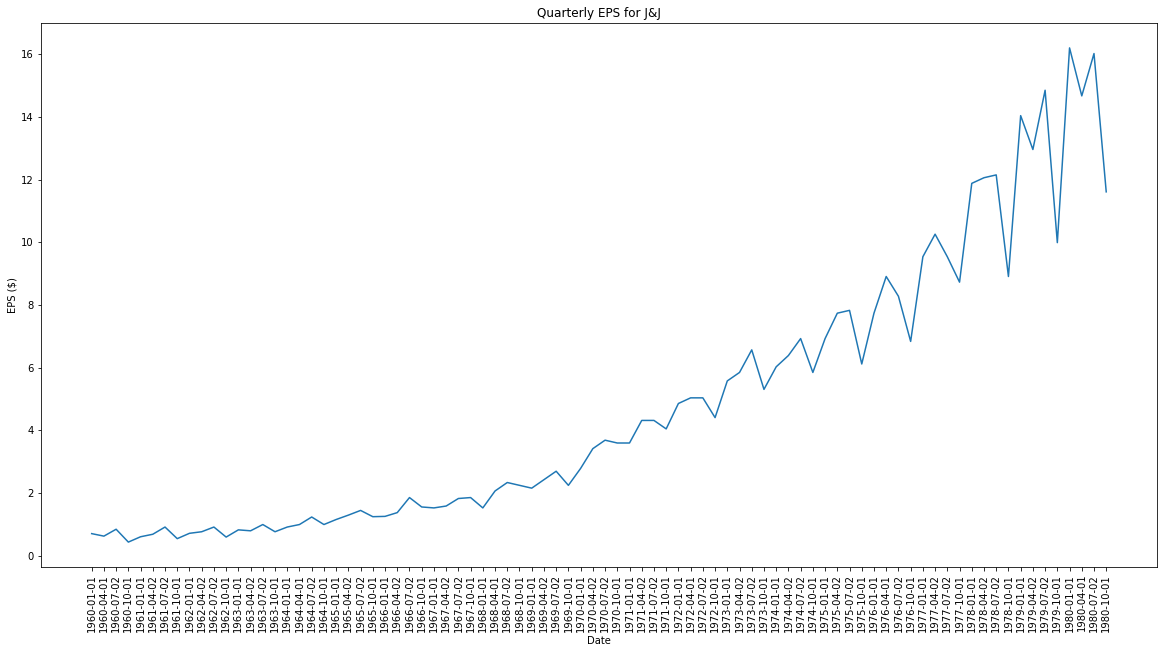

In [5]:
plt.plot(
    data['date'],
    data['data']
)
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

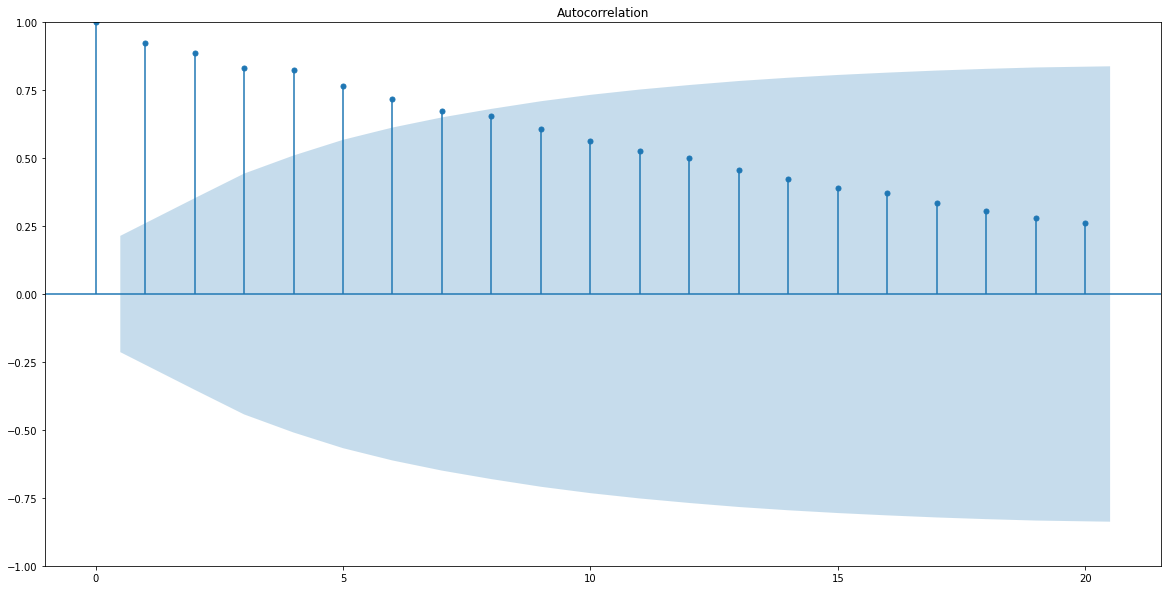

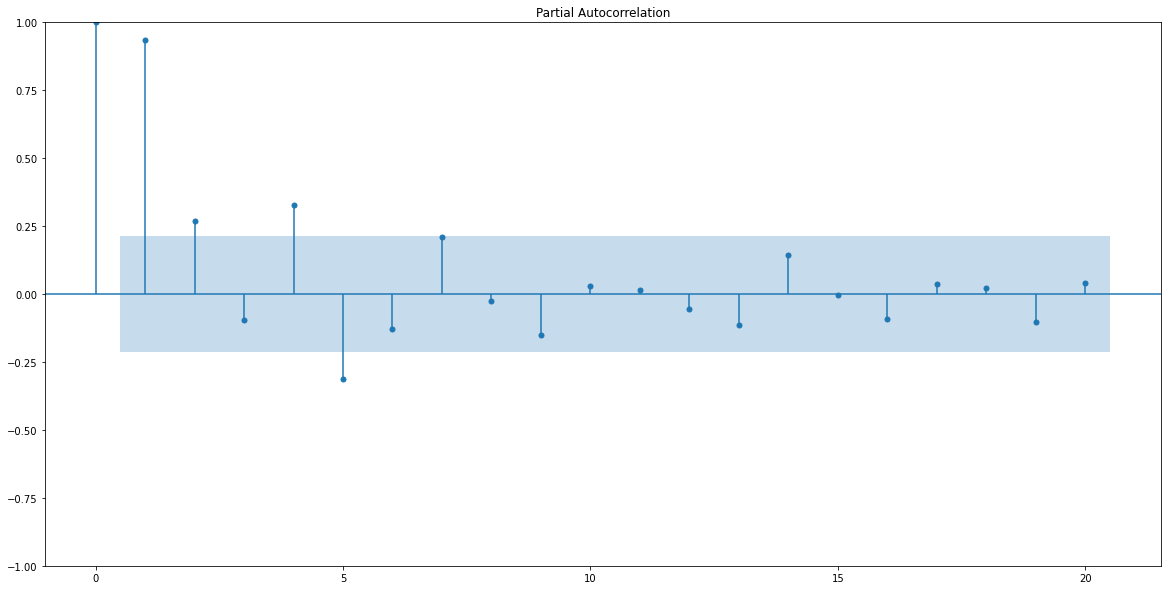

In [6]:
plot_acf(data['data']);
plot_pacf(data['data']);

In [7]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


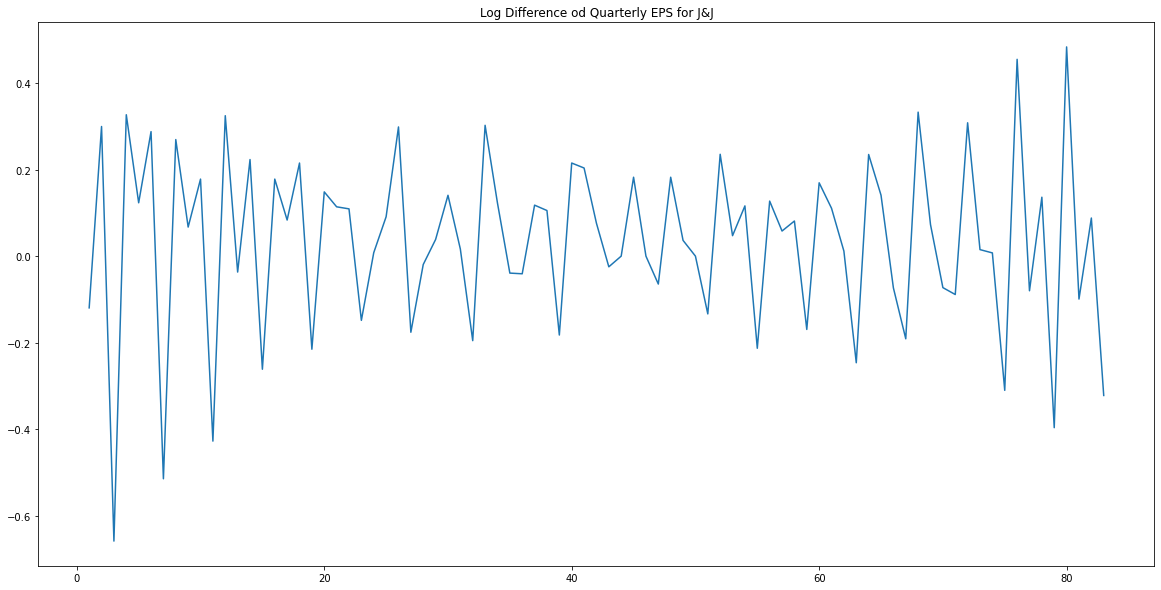

In [8]:
plt.plot(data['data_tr_1'])
plt.title('Log Difference od Quarterly EPS for J&J')
plt.show()

In [9]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistics: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistics: -4.317043945811841
p-value: 0.0004149731404440583


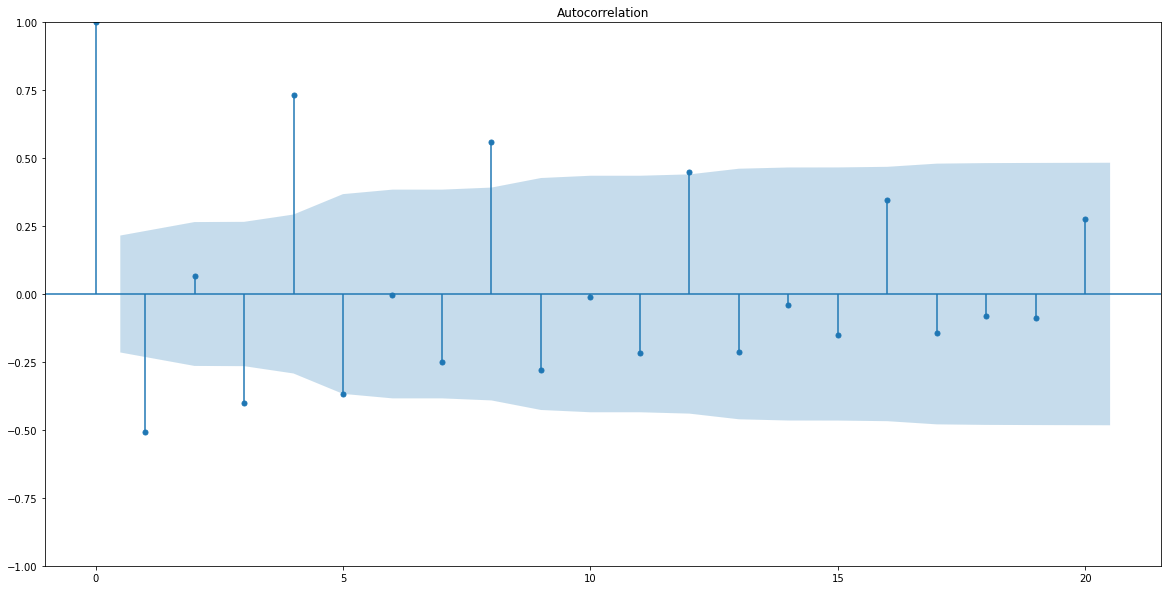

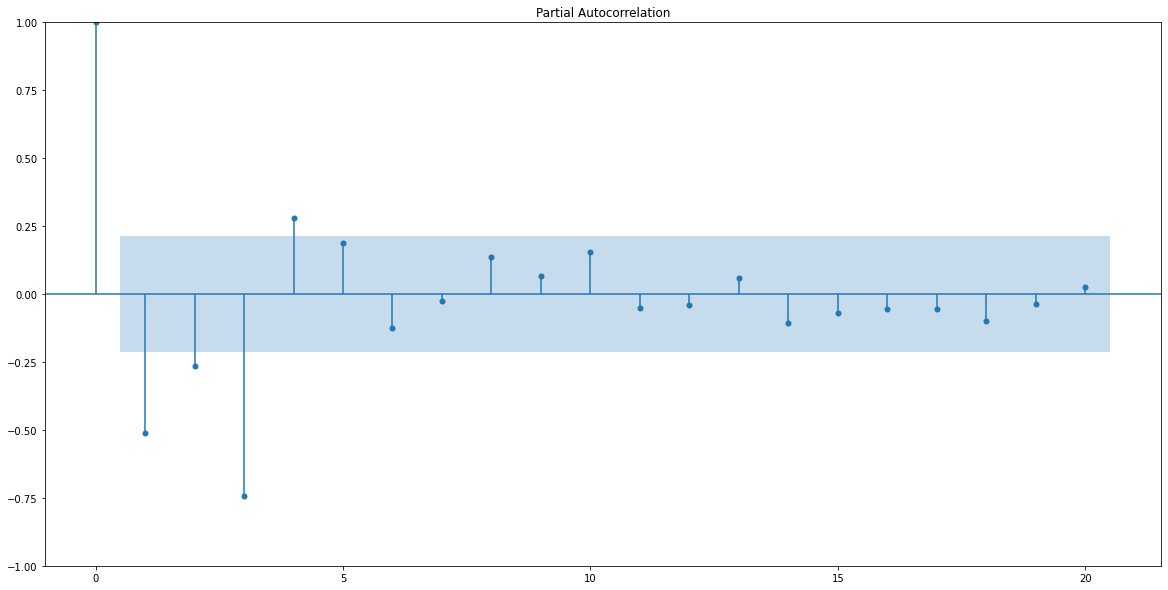

In [10]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);

In [14]:
def optimize_arima(endog, order_list):
    """
        Returns a dataframe with parameters and corresponding AIC
        
        order_list : list with (p,d,q) tuples
        endog : the observed variables
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic = model.aic 
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending = True).reset_index(drop=True)
    
    return result_df

In [15]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [16]:
result_df = optimize_arima(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.322006
1,"(4, 1, 6)",115.859419
2,"(7, 1, 1)",116.059827
3,"(5, 1, 3)",116.534597
4,"(5, 1, 4)",117.243416
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [17]:
best_model = SARIMAX(data['data'], order = (6,1,3), simple_differencing=False)
res = best_model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.661
Date:                Mon, 04 Jul 2022   AIC                            115.322
Time:                        12:01:50   BIC                            139.510
Sample:                             0   HQIC                           125.040
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4683      0.122    -12.072      0.000      -1.707      -1.230
ar.L2         -0.7628      0.144     -5.305      0.000      -1.045      -0.481
ar.L3          0.0419      0.061      0.681      0.496      -0.079       0.162
ar.L4          1.0177      0.044     23.168      0.000       0.932       1.104
ar.L5          1.4267      0.129     11.040      0.000       1.173       1.680
ar.L6          0.7310      0.144      5.067      0.000       0.448       1.014
ma.L1          0.7162      0.119      6.023      0.000       0.483       0.949
ma.L2         -0.1569      0.108     -1.459      0.145      -0.368       0.054
ma.L3         -0.7308      0.076     -9.604      0.000      -0.880      -0.582
sigma2         0.1525      0.024      6.386      0.000       0.106       0.199
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                62.45
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):              39.33   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

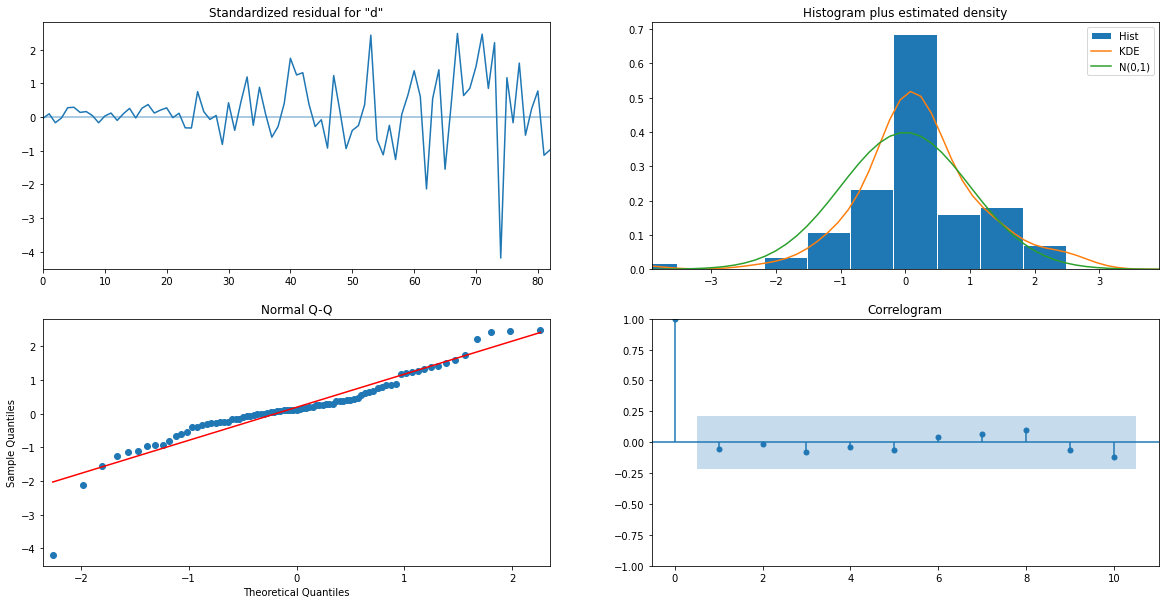

In [18]:
res.plot_diagnostics();

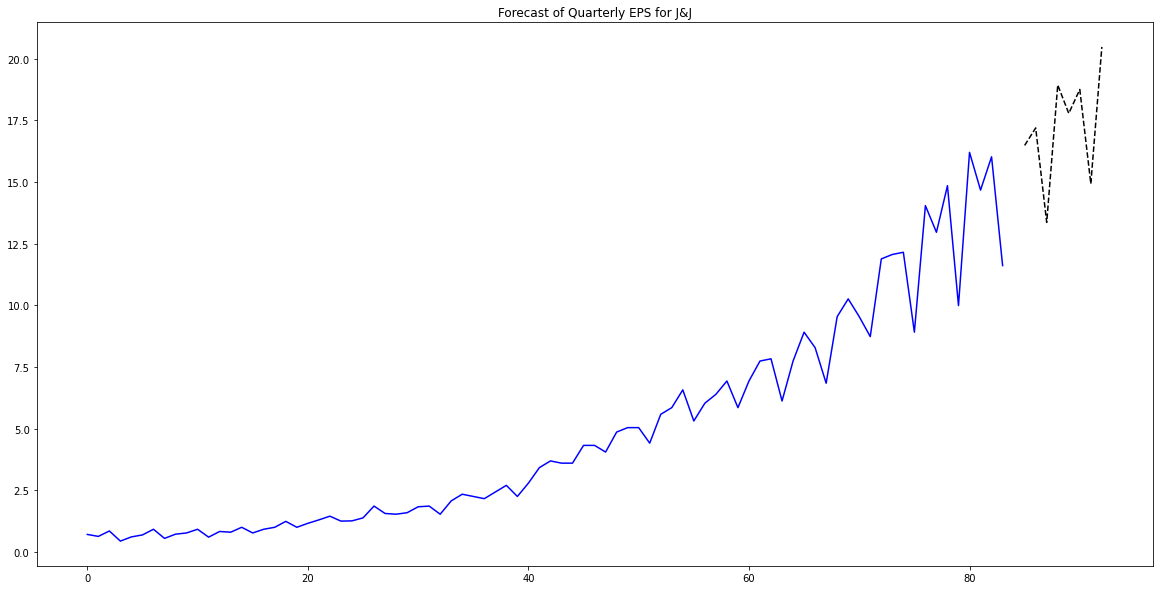

In [20]:
n_forecast = 8
predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))


fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Quarterly EPS for J&J')
plt.show()

In [21]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.680061
3,1960-10-01,0.44,-0.658462,0.721883
4,1961-01-01,0.61,0.326684,0.649139
5,1961-04-02,0.69,0.123233,0.527520
6,1961-07-02,0.92,0.287682,0.789033
7,1961-10-01,0.55,-0.514455,0.487575
8,1962-01-01,0.72,0.269333,0.649838
9,1962-04-02,0.77,0.067139,0.751397


In [23]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE: {mse}')

MSE: 0.15995530515456316
